# Task for Today  

***

## Food Image Classification  

Given *images of 101 different foods*, let's try to classifify the **food** present in a given image.

We will use a TensorFlow/Keras pretrained MobileNetV2 CNN to make our predictions.

# Getting Started

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
image_dir = Path('../input/food41/images')
test_image_dir = Path('../input/fooddataset/Food')

# Creating File DataFrame

In [5]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [6]:
image_df

,Filepath,Label
0,../input/food41/images/greek_salad/1330935.jpg,greek_salad
1,../input/food41/images/pancakes/3562559.jpg,pancakes
2,../input/food41/images/beef_carpaccio/484148.jpg,beef_carpaccio
3,../input/food41/images/french_fries/421038.jpg,french_fries
4,../input/food41/images/bread_pudding/689770.jpg,bread_pudding
...,...,...
10095,../input/food41/images/shrimp_and_grits/149216...,shrimp_and_grits
10096,../input/food41/images/sushi/2674024.jpg,sushi
10097,../input/food41/images/poutine/508222.jpg,poutine
10098,../input/food41/images/paella/265807.jpg,paella


In [7]:
filepaths_test = list(test_image_dir.glob(r'**/*.jpg*'))
filepaths_test.extend(list(test_image_dir.glob(r'**/*.png*')))
filepaths_test = pd.Series(filepaths_test, name='Filepath').astype(str)
image_test_df = pd.concat([filepaths_test], axis=1)

In [8]:
image_test_df

,Filepath
0,../input/fooddataset/Food/20170521_091328.jpg
1,../input/fooddataset/Food/IMG_5028.jpg
2,../input/fooddataset/Food/IMG_9594.jpg
3,../input/fooddataset/Food/IMG_7895.jpg
4,../input/fooddataset/Food/marine iguana huntin...
...,...
663,../input/fooddataset/Food/IMG_7004.png
664,../input/fooddataset/Food/IMG_7003.png
665,../input/fooddataset/Food/IMG_5940.png
666,../input/fooddataset/Food/IMG_7007.png


In [9]:
image_df['Label'].value_counts()

miso_soup              100
waffles                100
spaghetti_carbonara    100
escargots              100
chicken_wings          100
                      ... 
edamame                100
cannoli                100
beef_carpaccio         100
bibimbap               100
croque_madame          100
Name: Label, Length: 101, dtype: int64

# Train-Test Split

In [10]:
train_df = image_df
test_df = image_test_df

# Creating Generators

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,
    batch_size=32,
    shuffle=False,
    validate_filenames=False
)

Found 8080 validated image filenames belonging to 101 classes.
Found 2020 validated image filenames belonging to 101 classes.
Found 668 non-validated image filenames.


# Modeling

In [13]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [14]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Training

In [15]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
253/253 [==============================] - 124s 467ms/step - loss: 4.1312 - accuracy: 0.1063 - val_loss: 2.7908 - val_accuracy: 0.3144
Epoch 2/100
253/253 [==============================] - 53s 211ms/step - loss: 2.3287 - accuracy: 0.4103 - val_loss: 2.4160 - val_accuracy: 0.3980
Epoch 3/100
253/253 [==============================] - 53s 211ms/step - loss: 1.7298 - accuracy: 0.5478 - val_loss: 2.3489 - val_accuracy: 0.4337
Epoch 4/100
253/253 [==============================] - 54s 213ms/step - loss: 1.4549 - accuracy: 0.6078 - val_loss: 2.3181 - val_accuracy: 0.4426
Epoch 5/100
253/253 [==============================] - 54s 212ms/step - loss: 1.1586 - accuracy: 0.6820 - val_loss: 2.3922 - val_accuracy: 0.4396
Epoch 6/100
253/253 [==============================] - 53s 210ms/step - loss: 0.9352 - accuracy: 0.7487 - val_loss: 2.4757 - val_accuracy: 0.4460
Epoch 7/100
253/253 [==============================] - 53s 211ms/step - loss: 0.7324 - accuracy: 0.8012 - val_loss: 2.5901 

# Results

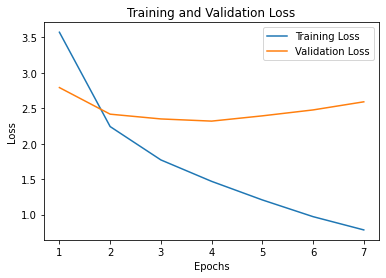

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

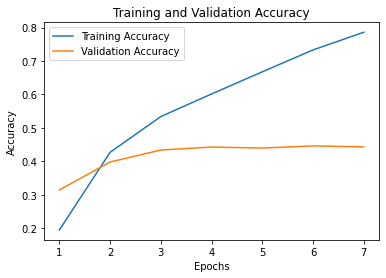

In [18]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [22]:
predictions = np.argmax(model.predict(test_images), axis=1).tolist()

In [23]:
predictions

[86,
 88,
 72,
 29,
 21,
 16,
 95,
 52,
 21,
 81,
 95,
 36,
 81,
 69,
 31,
 62,
 14,
 35,
 31,
 56,
 71,
 36,
 76,
 57,
 13,
 26,
 95,
 73,
 69,
 69,
 50,
 31,
 79,
 27,
 67,
 35,
 70,
 35,
 95,
 31,
 31,
 43,
 21,
 87,
 36,
 14,
 5,
 81,
 72,
 57,
 66,
 35,
 36,
 13,
 72,
 96,
 56,
 0,
 7,
 16,
 83,
 74,
 36,
 71,
 35,
 35,
 56,
 14,
 70,
 35,
 100,
 36,
 81,
 69,
 35,
 12,
 47,
 86,
 62,
 86,
 10,
 39,
 95,
 86,
 31,
 95,
 16,
 41,
 22,
 72,
 53,
 31,
 80,
 35,
 86,
 62,
 23,
 95,
 87,
 47,
 16,
 35,
 67,
 36,
 86,
 44,
 80,
 50,
 67,
 72,
 24,
 95,
 64,
 35,
 69,
 73,
 29,
 57,
 47,
 80,
 99,
 69,
 32,
 87,
 29,
 12,
 81,
 69,
 35,
 73,
 7,
 7,
 27,
 73,
 50,
 81,
 35,
 14,
 96,
 90,
 31,
 60,
 73,
 50,
 38,
 32,
 86,
 71,
 18,
 94,
 27,
 37,
 95,
 35,
 56,
 74,
 60,
 36,
 95,
 13,
 21,
 67,
 79,
 7,
 65,
 23,
 50,
 22,
 95,
 31,
 84,
 18,
 70,
 69,
 41,
 7,
 73,
 13,
 29,
 21,
 95,
 5,
 69,
 35,
 72,
 97,
 69,
 87,
 65,
 36,
 14,
 38,
 0,
 31,
 16,
 72,
 86,
 22,
 35,
 95,
 53,
 31

In [24]:
for i in range(len(predictions)):
    for key, value in train_images.class_indices.items():
            if value == predictions[i]:
                predictions[i] = key
predictions

['sashimi',
 'seaweed_salad',
 'pancakes',
 'cup_cakes',
 'chocolate_cake',
 'cheese_plate',
 'sushi',
 'gyoza',
 'chocolate_cake',
 'ramen',
 'sushi',
 'falafel',
 'ramen',
 'oysters',
 'donuts',
 'macaroni_and_cheese',
 'carrot_cake',
 'escargots',
 'donuts',
 'huevos_rancheros',
 'paella',
 'falafel',
 'pizza',
 'hummus',
 'caprese_salad',
 'crab_cakes',
 'sushi',
 'panna_cotta',
 'oysters',
 'oysters',
 'grilled_salmon',
 'donuts',
 'prime_rib',
 'creme_brulee',
 'omelette',
 'escargots',
 'pad_thai',
 'escargots',
 'sushi',
 'donuts',
 'donuts',
 'fried_calamari',
 'chocolate_cake',
 'scallops',
 'falafel',
 'carrot_cake',
 'beet_salad',
 'ramen',
 'pancakes',
 'hummus',
 'nachos',
 'escargots',
 'falafel',
 'caprese_salad',
 'pancakes',
 'tacos',
 'huevos_rancheros',
 'apple_pie',
 'bibimbap',
 'cheese_plate',
 'red_velvet_cake',
 'peking_duck',
 'falafel',
 'paella',
 'escargots',
 'escargots',
 'huevos_rancheros',
 'carrot_cake',
 'pad_thai',
 'escargots',
 'waffles',
 'falafel

In [25]:
train_images.class_indices

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

In [26]:
predictionsSeries = pd.Series(predictions, name='Predictions')
predictedImages = pd.concat([test_df, predictionsSeries], axis=1)
predictedImages

,Filepath,Predictions
0,../input/fooddataset/Food/20170521_091328.jpg,sashimi
1,../input/fooddataset/Food/IMG_5028.jpg,seaweed_salad
2,../input/fooddataset/Food/IMG_9594.jpg,pancakes
3,../input/fooddataset/Food/IMG_7895.jpg,cup_cakes
4,../input/fooddataset/Food/marine iguana huntin...,chocolate_cake
...,...,...
663,../input/fooddataset/Food/IMG_7004.png,creme_brulee
664,../input/fooddataset/Food/IMG_7003.png,creme_brulee
665,../input/fooddataset/Food/IMG_5940.png,pho
666,../input/fooddataset/Food/IMG_7007.png,pancakes


In [27]:
!cd /kaggle/working
predictedImages.to_csv('mycsvfile.csv')